## Air quality prediction with PyTorch MLP.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
path = os.getcwd()
path_pdf = os.path.join(path, 'AirQualityUCI.xlsx')

In [3]:
df = pd.read_excel(path_pdf)

### Data exploration

In [5]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754,NaN,NaN
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487,NaN,NaN
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239,NaN,NaN
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713,NaN,NaN
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794,NaN,NaN


In [6]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')

There are two empty columns with names Unnamed: 15 and Unnamed: 16. We'll delete them.

In [7]:
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis = 1, inplace = True)

#### Columns Description

In [9]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')

In [1]:
# 0 Date           (DD/MM/YYYY)
# 1 Time           (HH.MM.SS)
# 2 CO(GT)         hourly averaged concentration CO in mg/m^3 (reference analyzer)
# 3 PT08.S1(CO)    (tin oxide) hourly averaged sensor response (nominally CO targeted)
# 4 NMHC(GT)       hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
# 5 C6H6(GT)       hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
# 6 PT08.S2(NMHC)  (titania) hourly averaged sensor response (nominally NMHC targeted)
# 7 NOx(GT)        hourly averaged NOx concentration in ppb (reference analyzer)
# 8 PT08.S3(NOx)   (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
# 9 NO2(GT)        hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
# 10 PT08.S4(NO2)  (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
# 11 PT08.S5(O3)   (indium oxide) hourly averaged sensor response (nominally O3 targeted)
# 12 T             Temperature in °C
# 13 RH            Relative Humidity (%)
# 14 AH            Absolute Humidity

In [11]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In the description of dataset it's said that a value -200 means a missing value. Let's check how many missing values are in the dataset. 

In [13]:
for col in df:
    print(col, len(df[df[col]== -200]))

Date 0
Time 0
CO(GT) 1683
PT08.S1(CO) 366
NMHC(GT) 8443
C6H6(GT) 366
PT08.S2(NMHC) 366
NOx(GT) 1639
PT08.S3(NOx) 366
NO2(GT) 1642
PT08.S4(NO2) 366
PT08.S5(O3) 366
T 366
RH 366
AH 366


The major number of missing values is in the column NMHC(GT), NOx(GT), NO2(GT).

In [15]:
df.drop(['Date', 'Time', 'NMHC(GT)'], axis = 1, inplace = True)

In [16]:
# then for the rest of columns let's filter -200

for col in df.columns:
    df = df[df[col] != -200]

In [17]:
df.reset_index(drop = True, inplace = True)

In our case we will predict CO(GT), which is hourly averaged concentration CO in mg/m^3. Other variables will be features.


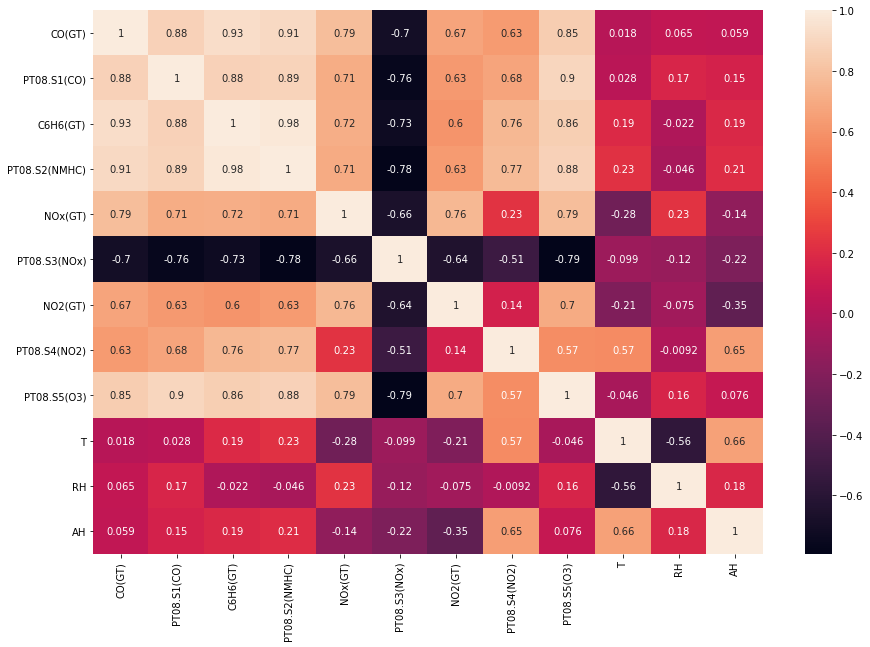

In [19]:
import seaborn as sns
# correlation heatmaps

plt.figure(figsize = (15, 10))
corr = df.corr()
sns.heatmap(corr, annot = True)
plt.show()

Let's check the correlations with CO - our target.

There are many feature columns highly correlated with the target. The most correlated are C6H6(GT), PT08.S2(NMHC), PT08.S1(CO).

In [22]:
corr['CO(GT)'].sort_values(ascending=False)

CO(GT)           1.000000
C6H6(GT)         0.930026
PT08.S2(NMHC)    0.914316
PT08.S1(CO)      0.877019
PT08.S5(O3)      0.853481
NOx(GT)          0.786483
NO2(GT)          0.674026
PT08.S4(NO2)     0.630828
RH               0.064758
AH               0.059345
T                0.018336
PT08.S3(NOx)    -0.701025
Name: CO(GT), dtype: float64

Split to Features and Target.

In [24]:
target = df['CO(GT)']
df = df.drop('CO(GT)', axis = 1)